# Deep Learning &mdash; Assignment 1

First assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_September 2020_

-----

**Names:**
Enrico Schmitz (s1047521) & Charlotte Cambier van Nooten (s1044122)

**Group:**
Group 22

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.

## Objectives

In this assignment you will
1. Experiment with gradient descent optimization;
2. Derive and implement gradients for binary cross-entropy loss, the sigmoid function and a linear layer;
3. Test your gradient implementations with the finite differences method;
4. Use these components to implement and train a simple neural network.

In [2]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

## 1.1 Gradient descent optimization

Consider the following function with two parameters and its derivatives:
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}

In [258]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)
def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2
def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

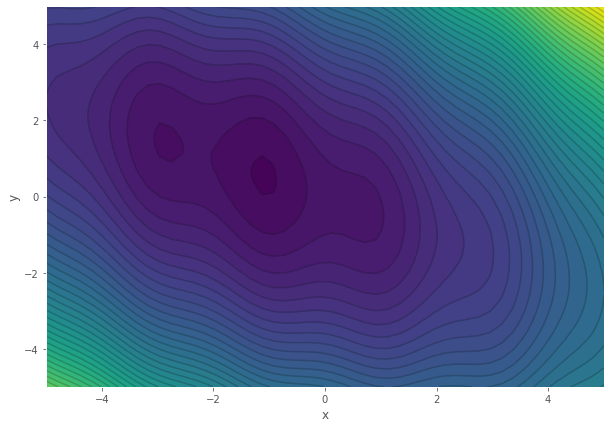

In [259]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10, 7))
plot_f_contours()

### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**Implement the gradient descent updates for $x$ and $y$ in the function below:**

In [260]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x -= (step_size * dx)  
        y -= (step_size * dy)  

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [261]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')
    
    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

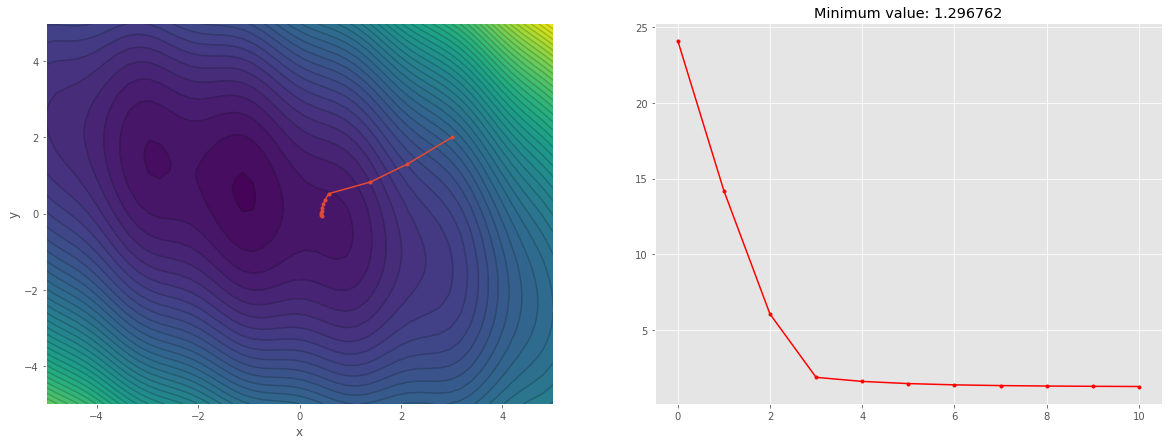

In [262]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=10)
plot_gradient_descent_results(*results)

**Does it find the minimum of the function? What happens?**

No, the minimum is not met, which could be caused by the fact that the stepsize is very small and the number of choosen steps.

**Try a few different values for the `step_size` and the number of `steps` to get closes to the optimal solution:**

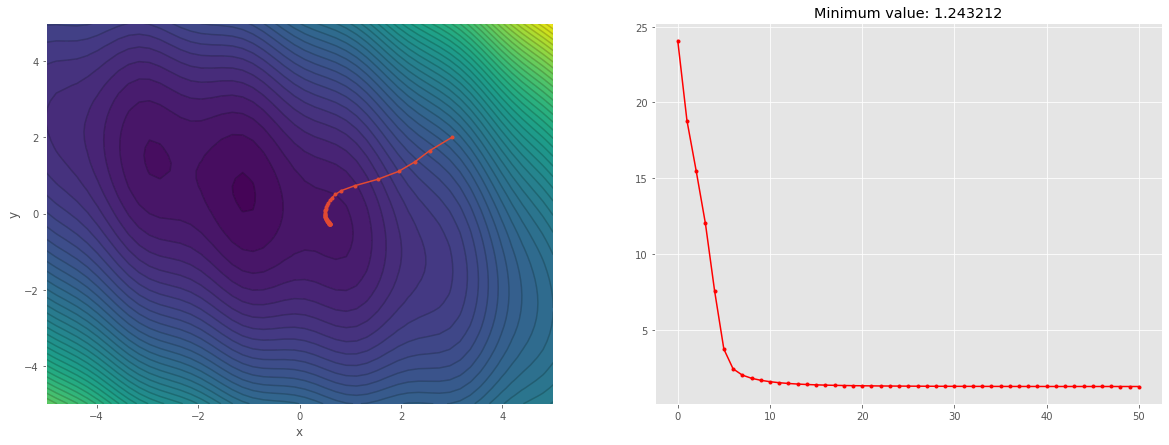

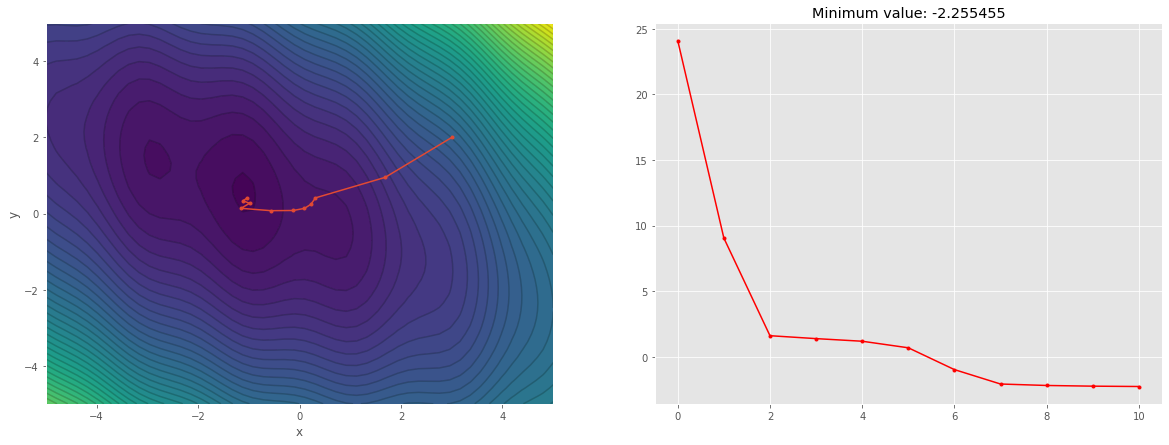

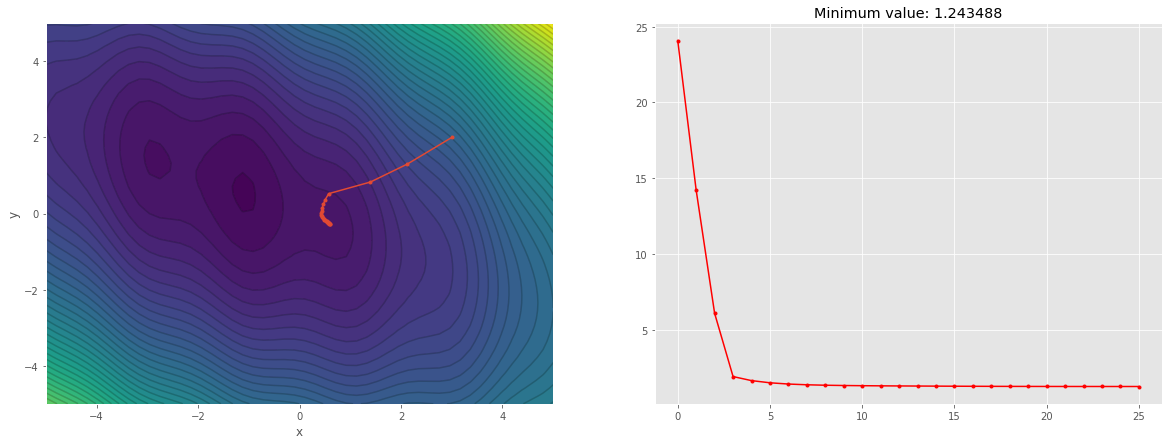

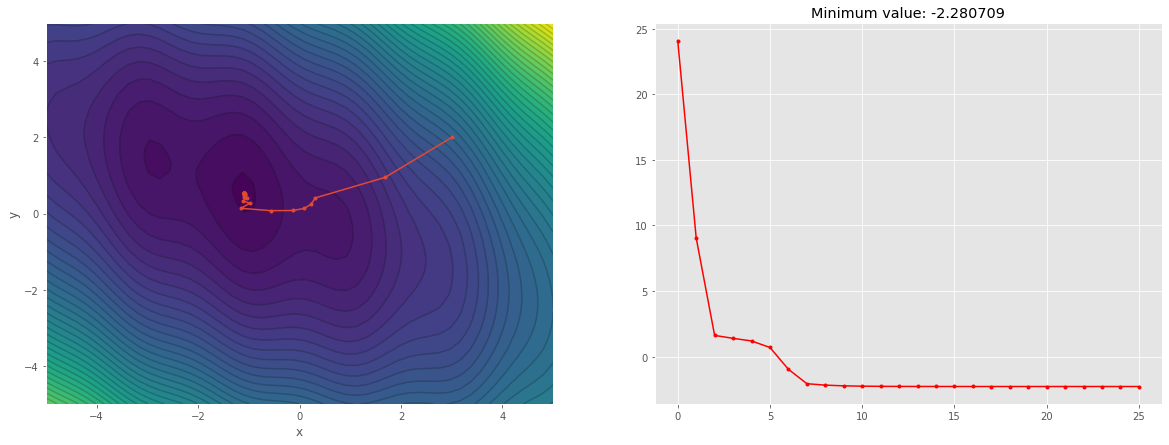

In [263]:
# Tune the parameters to find a better optimum
results = optimize_f(x=3, y=2, step_size=0.05, steps=50,)
plot_gradient_descent_results(*results)

results = optimize_f(x=3, y=2, step_size=0.15, steps=10,)
plot_gradient_descent_results(*results)

results = optimize_f(x=3, y=2, step_size=0.1, steps=25,)
plot_gradient_descent_results(*results)

results = optimize_f(x=3, y=2, step_size=0.15, steps=25,)
plot_gradient_descent_results(*results)

**Were you able to find a step size that reached the global optimum? If not, why not?**

Yes, stepsize = 0.15 and steps = 25

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}

**Update your optimization function to use this step size schedule:**

In [264]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        eta = step_size * (decay^step)
        x -= (eta * dx)  
        y -= (eta * dy)  

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

**Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:**

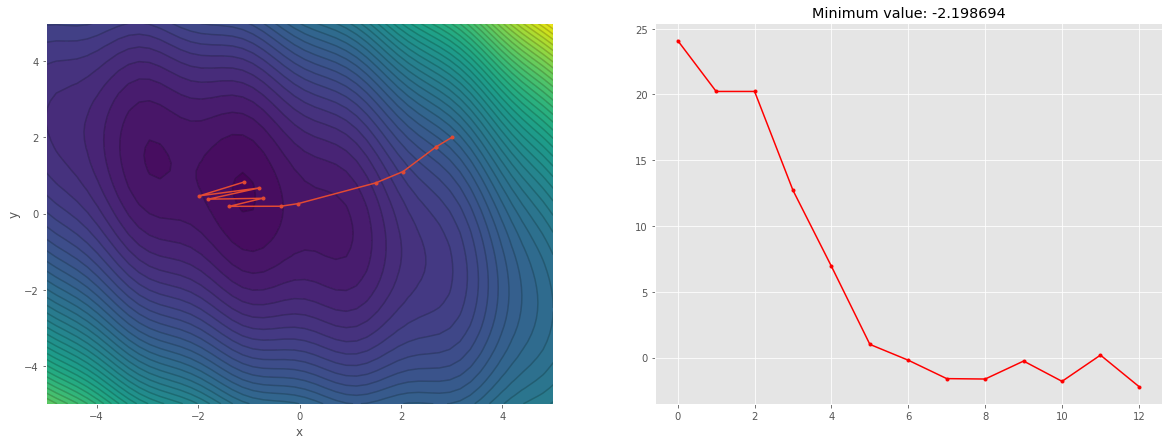

In [265]:
# Tune the parameters to find the local optimum
results = optimize_f(x=3, y=2, step_size=0.035, steps=12, decay=1)
plot_gradient_descent_results(*results)

We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}

![Sigmoid](attachment:sigmoid.png)

**Give the derivative of the sigmoid function:**

\begin{align}
\frac{\partial \sigma(x)}{\partial x} &= \frac{e^{-x}}{(1 + e^{-x})^2} \\
\end{align}


**Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:**

In [266]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))

x: [ 1.868385 -0.208946 -6.349867 -0.046388  3.978798]
sigmoid(x): [0.866271 0.447953 0.001744 0.488405 0.981635]
sigmoid_grad(x): [0.115845 0.247291 0.001741 0.249866 0.018027]


To check that the gradient implementation is correct, we can compute the numerical derivative using the finite difference method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:**

In [267]:
# start with some random inputs
x = np.random.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic', sigmoid_grad(x))

# The numerical gradient
constant = 1
def numerical_grad(x, constant):
    return (sigmoid(x+(0.5*constant)) - sigmoid(x-(0.5*constant)))/constant
print ('Numerical', numerical_grad(x, constant))


Symbolic [0.239604 0.246677 0.144572 0.164451 0.24885 ]
Numerical [0.235321 0.241856 0.145309 0.164485 0.243859]


**Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?**

No, but when rounding the numbers, there are pretty similar (in two decimals) but this is highly dependend on the randomness of x

**If there is a visible difference between the two gradients, please try to make this a small as possible before you continue.**

## Rectified linear units (ReLU)

The rectified linear unit is defined as:
\begin{align}
  f(x) = \max(0, x)
\end{align}

![relu.png](attachment:relu.png)

**Give the derivative of the ReLU function:**

\begin{align}
  \frac{\partial f(x)}{\partial x} &= f'(x) = \begin{Bmatrix} 0 & x<0 \\ 1 & x\geq0
  \end{Bmatrix}
\end{align}

with x in range {0,inf}


**Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite differences method to check that the gradient is correct:**

In [3]:
def relu(x):
    return np.maximum(0,x)

def relu_grad(x):
    return np.where(x <= 0, 0, 1)

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))
print()

# Compute and compare the symbolic and numerical gradients
# compute the symbolic gradient
print('Symbolic', relu_grad(x))

# compute the numerical gradient
constant = 1
def numerical_grad(x, constant):
    return (relu(x+(0.5*constant)) - relu(x-(0.5*constant)))/constant
print ('Numerical', numerical_grad(x, constant))


x: [ 6.069506 -9.242223  6.1033   -0.386536  9.431524]
relu(x): [6.069506 0.       6.1033   0.       9.431524]
relu_grad(x): [1 0 1 0 1]

Symbolic [1 0 1 0 1]
Numerical [1.       0.       1.       0.113464 1.      ]


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

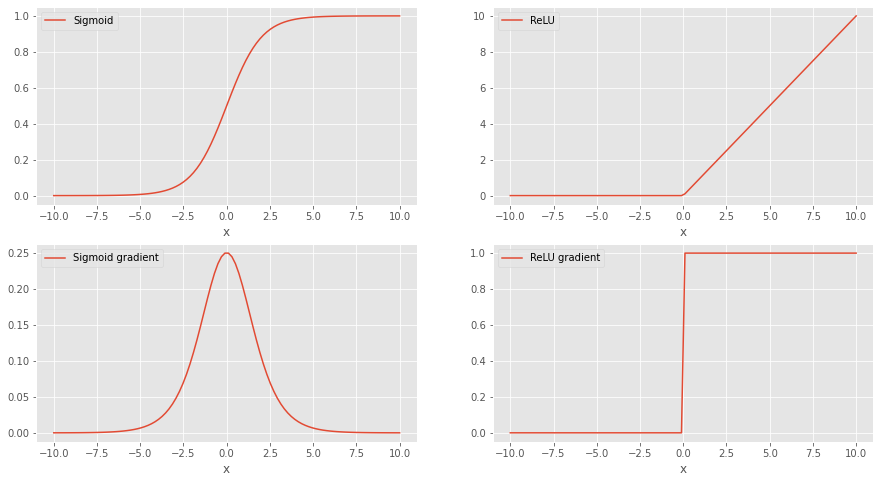

In [269]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in (0, 1)$? Why?**



We would recommend the sigmoid function, is this way all output probabilities could be met.

**Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function?**



The disadvantage of sigmoid is that the gradient can 'disappear' meaning that the gradient becomes infinitly small. 
The constant gradient of ReLUs results in faster learning.
But ReLU can have a really big activation while the sigmoid keeps it in check.

### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in (0, 1)$:

\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}

To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**Derive the gradient for the BCE loss:**

\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &= \frac{-y}{\hat{y}} + \frac{1-y}{1-\hat{y}}
\end{align}


**Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite differences method to check that the gradient is correct:**

In [270]:
def bce_loss(y, y_hat):
    return -((y*np.log(y_hat)) + ((1-y)*np.log(1-y_hat)))

def bce_loss_grad(y, y_hat):
    return ((-y/y_hat)+((1-y)/(1-y_hat)))

# try with some random inputs
y = np.random.randint(2, size=5)
y_hat = np.random.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print()

# Compute and compare the symbolic and numerical gradients
# compute the symbolic gradient
print('Symbolic', bce_loss_grad(y, y_hat))

# compute the numerical gradient
constant = 1*(10**(-3))
def numerical_grad(y, y_hat, constant):
    plus = y_hat+(0.5*constant)
    plus[plus > 1] = 1
    minus = y_hat-(0.5*constant)        
    minus[minus > 1] = 1
    return (bce_loss(y, plus) - bce_loss(y,minus))/constant
print ('Numerical', numerical_grad(y, y_hat, constant))

y: [0 0 1 1 1]
y_hat: [0.721763 0.809977 0.948659 0.136043 0.702263]
bceloss(y, y_hat): [1.279282 1.66061  0.052706 1.994785 0.353447]

Symbolic [ 3.594057  5.262518 -1.054119 -7.350623 -1.423968]
Numerical [ 3.59406   5.26253  -1.054119 -7.350656 -1.423968]


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:**

\begin{align}
  \nabla_\mathbf{x} \mathbf{y} &= w\\
  \nabla_\mathbf{W} \mathbf{y} &= x\\
  \nabla_\mathbf{b} \mathbf{y} &= 1\\
\end{align}


**Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:**

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial y}\frac{\partial \mathcal{y}}{\partial x} = \frac{\partial \mathcal{L}}{\partial y} * w \\
  \nabla_\mathbf{W} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial w} = \frac{\partial \mathcal{L}}{\partial y}\frac{\partial \mathcal{y}}{\partial w} = \frac{\partial \mathcal{L}}{\partial y} * x\\
  \nabla_\mathbf{b} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial b} = \frac{\partial \mathcal{L}}{\partial y}\frac{\partial \mathcal{y}}{\partial b} = \frac{\partial \mathcal{L}}{\partial y} * 1\\
\end{align}


## 1.3 Implement a one-layer model

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

\begin{align}
h = \mathbf{x}^T \mathbf{w} + b \\
\hat{y} = \sigma(h) \\
\end{align}

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$:

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} = \frac{\partial \mathcal{L}}{\partial h} * w
\end{align}

**Complete the implementation below:**

In [271]:
# initialize parameters
w = np.random.uniform(size=5)
b = np.random.rand()

# implement the model
def fn(x, y):
    # Forward: compute h, y_hat, loss
    h = np.transpose(x)*w +b
    y_hat = sigmoid(h)
    loss = bce_loss(y,y_hat)
    
    # Backward: compute grad_y_hat, grad_h, grad_x
    grad_y_hat = bce_loss_grad(y,y_hat)
    grad_h = grad_y_hat * (y_hat*(1-y_hat))
    grad_x = grad_h * w
    
    return loss, grad_x

# test with a random input
x = np.random.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

Loss [0.379228 0.33879  0.282411 0.364902 0.315778]
Gradient [-0.087698 -0.251144 -0.131404 -0.046198 -0.117938]


**Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [272]:
# start with some random inputs
x = np.random.uniform(size=5)
y = 1

# set epsilon to a small value
eps = 0.00001

numerical_grad = np.zeros(x.shape)
# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps / 2
    x_b[i] -= eps / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a[i] - loss_b[i]) / eps

# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)
    
print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)

Symbolic gradient
[-0.091366 -0.266967 -0.15493  -0.049337 -0.125149]
Numerical gradient
[-0.091366 -0.266967 -0.15493  -0.049337 -0.125149]


## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions

We will now construct a simple neural network. We need to implement the folowing objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the weights, based on the gradient computed by `backward`.

**Implement a class `Linear` that computes `y = x*W + b`:**

In [273]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = np.random.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
        # Forward pass
        y = np.dot(x, self.W) + self.b 
        return y

    def backward(self, x, dy):
        # Backward pass,
        # given dy, compute the gradients for x, W and b
        self.dW = np.dot(np.transpose(x), dy)
        self.db = np.sum(dy, axis=0)

        dx = np.dot(dy, np.transpose(self.W))
        return dx
    
    def step(self, step):
        # Apply a gradient descent update step
        self.W -= step*self.dW 
        self.b -= step*self.db 
        
    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each
# dimension, so you'll get an error if you mix them up.
x = np.random.uniform(size=(3, 5))

layer = Linear(5, 7)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[ 0.088589  0.053839  0.196951 -0.733291  0.158459 -0.287175 -0.281508]
 [ 0.595153  0.456923 -0.222944 -0.436372  0.084474 -0.19464   0.006137]
 [ 0.257787  0.091876 -0.008774 -0.622285  0.059971 -0.205036 -0.252956]]
dx: [[-0.148991  0.603875 -0.797743 -0.165161  0.375038]
 [-0.148991  0.603875 -0.797743 -0.165161  0.375038]
 [-0.148991  0.603875 -0.797743 -0.165161  0.375038]]


**Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:**

In [274]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        # Forward pass
        y = 1/(1+np.exp(-x))
        return y

    def backward(self, x, dy):
        # Backward pass, return the gradient for x given dy
        h = self.forward(x)
        return np.multiply(np.multiply(h, (1 - h)), dy)
    
    def step(self, step_size):
        #raise NotImplementedError 
        pass 
        
    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
x = np.random.uniform(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[0.557279 0.691    0.559597 0.722976 0.527956]
 [0.633015 0.7076   0.571961 0.590955 0.643216]
 [0.541337 0.628078 0.54973  0.708921 0.64032 ]]
dx: [[0.246719 0.213519 0.246448 0.200282 0.249218]
 [0.232307 0.206902 0.244822 0.241727 0.229489]
 [0.248291 0.233596 0.247527 0.206352 0.23031 ]]


**Implement a class `ReLU` that computes `y = max(0, x)`:**

In [275]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        # Forward pass
        return np.maximum(0,x)  

    def backward(self, x, dy):
        # Backward pass, return the gradient for x given dy
        dx = np.array(dy, copy=True)
        # When x <= 0, we should set dx to 0 as well. 
        dx[x <= 0] = 0
        return dx
    
    def step(self, step_size):
        #raise NotImplementedError
        pass
    
    def __str__(self):
        return 'ReLU'


# try the new class with some random values
x = np.random.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[0.       0.       4.16977  0.       0.      ]
 [3.049805 0.749301 6.026863 0.       0.      ]
 [9.483777 0.       0.       1.289388 0.      ]]
dx: [[0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0.]]


### Verify the gradients (using provided code)

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**Run the code and check that the error is not too large.**

In [276]:
## Verify gradient computations for Linear
# test for dx
layer = Linear(5, 7)
def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=3 * 5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for dW
x = np.random.uniform(size=(3, 5))
layer = Linear(5, 7)
def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5 * 7))
print("err on dW:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for db
x = np.random.uniform(size=(3, 5))
layer = Linear(5, 7)
def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db
err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=7))                   
print("err on db:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 9.420986747813985e-07
err on dW: OK 5.764992251486723e-06
err on db: OK 0.0


In [277]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 2.3753528297198848e-08


In [278]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(1, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 0.0


## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**Read the code below:**

In [279]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

digits_x.shape: (1797, 64)
digits_y.shape: (1797,)
min, max values: -0.8117561971974786 1.847470154168513
labels: [0. 1.]


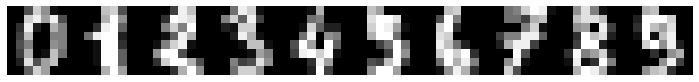

In [280]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

We divide the dataset in a train and a test set.

In [281]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
idxs = np.random.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test':  digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test':  digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

Training samples: 898
Test samples: 899


We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**Read through the code below.**

In [282]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**Train the network and inspect the results. Tune the hyperparameters to get a good result.**

Epoch   0: loss[train]= 0.4931  accuracy[train]= 0.7736  loss[test]= 0.3712  accuracy[test]= 0.8609
Epoch   1: loss[train]= 0.2999  accuracy[train]= 0.8908  loss[test]= 0.2803  accuracy[test]= 0.8954
Epoch   2: loss[train]= 0.2288  accuracy[train]= 0.9218  loss[test]= 0.2307  accuracy[test]= 0.9161
Epoch   3: loss[train]= 0.1838  accuracy[train]= 0.9402  loss[test]= 0.1959  accuracy[test]= 0.9322
Epoch   4: loss[train]= 0.1501  accuracy[train]= 0.9506  loss[test]= 0.1662  accuracy[test]= 0.9460
Epoch   5: loss[train]= 0.1267  accuracy[train]= 0.9621  loss[test]= 0.1479  accuracy[test]= 0.9494
Epoch   6: loss[train]= 0.1095  accuracy[train]= 0.9678  loss[test]= 0.1345  accuracy[test]= 0.9575
Epoch   7: loss[train]= 0.0962  accuracy[train]= 0.9701  loss[test]= 0.1255  accuracy[test]= 0.9621
Epoch   8: loss[train]= 0.0857  accuracy[train]= 0.9759  loss[test]= 0.1188  accuracy[test]= 0.9621
Epoch   9: loss[train]= 0.0769  accuracy[train]= 0.9770  loss[test]= 0.1141  accuracy[test]= 0.9632


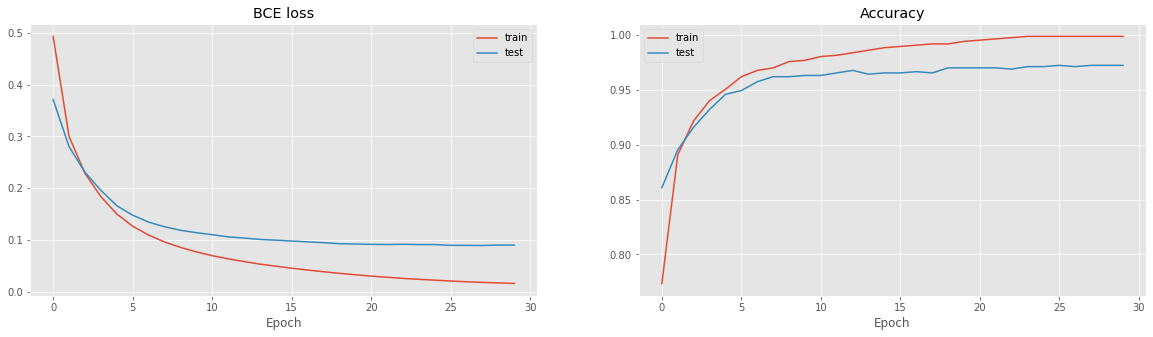

In [305]:
# construct network
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 1),
        Sigmoid()])

# Tune the hyperparameters
fit(net, x, y,
    epochs = 30,
    learning_rate = 0.005,
    mb_size = 30)

**Which of the hyperparameters (number of epochs, learning rate, minibatch size) was most important? How did they influence your results?**

Learning rate was the most important since it heavily influenced the accuracy the most while epoch just had to be big enough to give the network time to train.
Increasing epoch beyond 30 didn't seem te improve the score.

**Repeat the experiment with a the same network, but remove the ReLU activation in the middle: `[Linear, Linear, Sigmoid]`.**

Epoch   0: loss[train]= 0.4883  accuracy[train]= 0.7678  loss[test]= 0.3979  accuracy[test]= 0.8356
Epoch   1: loss[train]= 0.3370  accuracy[train]= 0.8586  loss[test]= 0.3585  accuracy[test]= 0.8540
Epoch   2: loss[train]= 0.3042  accuracy[train]= 0.8805  loss[test]= 0.3475  accuracy[test]= 0.8575
Epoch   3: loss[train]= 0.2893  accuracy[train]= 0.8839  loss[test]= 0.3441  accuracy[test]= 0.8632
Epoch   4: loss[train]= 0.2812  accuracy[train]= 0.8931  loss[test]= 0.3430  accuracy[test]= 0.8644
Epoch   5: loss[train]= 0.2763  accuracy[train]= 0.8966  loss[test]= 0.3421  accuracy[test]= 0.8667
Epoch   6: loss[train]= 0.2728  accuracy[train]= 0.9011  loss[test]= 0.3411  accuracy[test]= 0.8621
Epoch   7: loss[train]= 0.2701  accuracy[train]= 0.9023  loss[test]= 0.3398  accuracy[test]= 0.8609
Epoch   8: loss[train]= 0.2679  accuracy[train]= 0.9023  loss[test]= 0.3382  accuracy[test]= 0.8644
Epoch   9: loss[train]= 0.2660  accuracy[train]= 0.9000  loss[test]= 0.3365  accuracy[test]= 0.8644


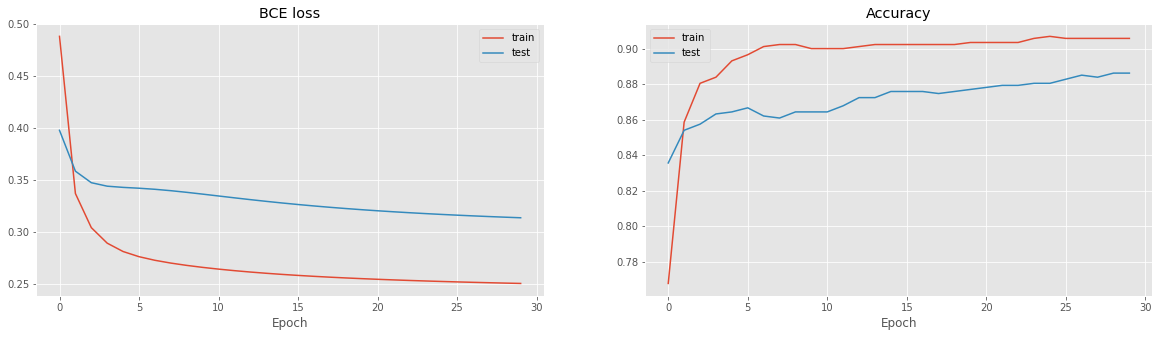

In [323]:
# construct network
net = Net([
        Linear(64, 32),
        Linear(32, 1),
        Sigmoid()])

fit(net, x, y,
    epochs = 30,
    learning_rate = 0.005,
    mb_size = 30)

**How does the performance of this network compare with the previous network. Can you explain this result? How does removing the ReLU affect the model?**

The graphs now show a indication of overfitting. 
The training accuracy is still high but lower than before, but the test accuracy is way worse.ow

**Create a network with one linear layer followed by a sigmoid activation:**

`net = Net([Linear(...), Sigmoid()]`

**Train this network. Compare the results with the `[Linear, ReLU, Linear, Sigmoid]` and `[Linear, Linear, Sigmoid]` networks you trained before, and explain the results.**

Epoch   0: loss[train]= 0.5071  accuracy[train]= 0.7780  loss[test]= 0.4170  accuracy[test]= 0.8419
Epoch   1: loss[train]= 0.3716  accuracy[train]= 0.8598  loss[test]= 0.3682  accuracy[test]= 0.8585
Epoch   2: loss[train]= 0.3332  accuracy[train]= 0.8708  loss[test]= 0.3463  accuracy[test]= 0.8638
Epoch   3: loss[train]= 0.3127  accuracy[train]= 0.8809  loss[test]= 0.3333  accuracy[test]= 0.8670
Epoch   4: loss[train]= 0.2994  accuracy[train]= 0.8836  loss[test]= 0.3245  accuracy[test]= 0.8705
Epoch   5: loss[train]= 0.2899  accuracy[train]= 0.8844  loss[test]= 0.3183  accuracy[test]= 0.8760
Epoch   6: loss[train]= 0.2828  accuracy[train]= 0.8871  loss[test]= 0.3135  accuracy[test]= 0.8797
Epoch   7: loss[train]= 0.2773  accuracy[train]= 0.8888  loss[test]= 0.3099  accuracy[test]= 0.8805
Epoch   8: loss[train]= 0.2728  accuracy[train]= 0.8905  loss[test]= 0.3069  accuracy[test]= 0.8807
Epoch   9: loss[train]= 0.2692  accuracy[train]= 0.8911  loss[test]= 0.3046  accuracy[test]= 0.8815


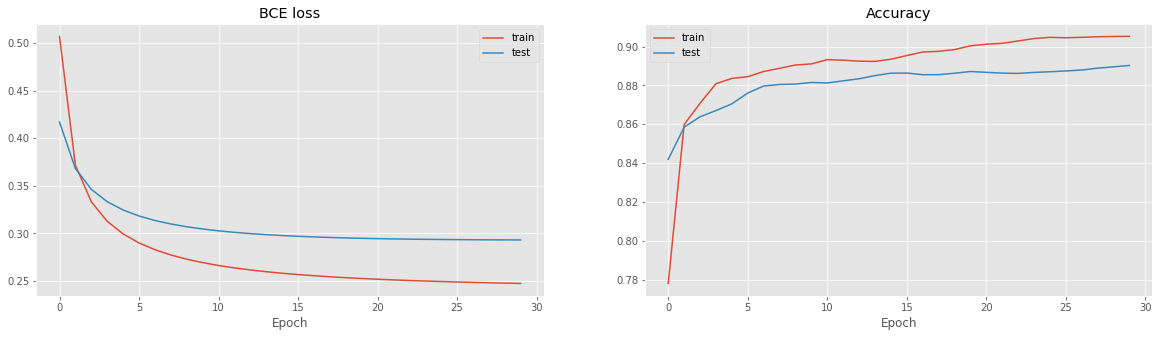

In [324]:
# construct network
net = Net([
        Linear(64, 32),
        Sigmoid()])

fit(net, x, y,
    epochs = 30,
    learning_rate = 0.005,
    mb_size = 30)

**Discuss your results.**

With this low amount of layers removing a layer is very influencial on your results.
Showing that the network requires these layers.

**Try a deeper network (e.g., four linear layers) to see if this can improve the results further.**

Epoch   0: loss[train]= 0.6849  accuracy[train]= 0.5977  loss[test]= 0.6687  accuracy[test]= 0.6138
Epoch   1: loss[train]= 0.6193  accuracy[train]= 0.7391  loss[test]= 0.5295  accuracy[test]= 0.8126
Epoch   2: loss[train]= 0.4226  accuracy[train]= 0.8690  loss[test]= 0.3342  accuracy[test]= 0.8770
Epoch   3: loss[train]= 0.3141  accuracy[train]= 0.8782  loss[test]= 0.2440  accuracy[test]= 0.9115
Epoch   4: loss[train]= 0.2150  accuracy[train]= 0.9218  loss[test]= 0.1835  accuracy[test]= 0.9287
Epoch   5: loss[train]= 0.1546  accuracy[train]= 0.9448  loss[test]= 0.1461  accuracy[test]= 0.9448
Epoch   6: loss[train]= 0.1153  accuracy[train]= 0.9598  loss[test]= 0.1301  accuracy[test]= 0.9552
Epoch   7: loss[train]= 0.0885  accuracy[train]= 0.9701  loss[test]= 0.1326  accuracy[test]= 0.9540
Epoch   8: loss[train]= 0.0754  accuracy[train]= 0.9770  loss[test]= 0.1356  accuracy[test]= 0.9598
Epoch   9: loss[train]= 0.0555  accuracy[train]= 0.9839  loss[test]= 0.1898  accuracy[test]= 0.9333


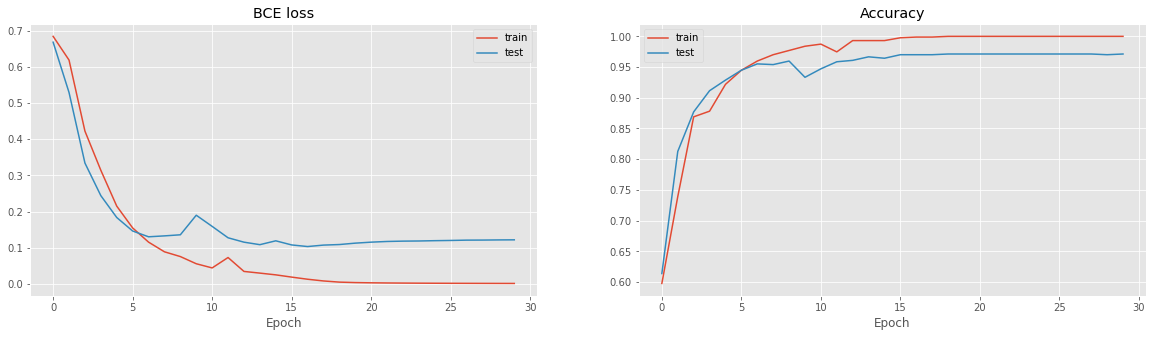

In [357]:
# construct network
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 16),
        Linear(16, 8),
        ReLU(),
        Linear(8, 1),
        Sigmoid()])

fit(net, x, y,
    epochs = 30,
    learning_rate = 0.005,
    mb_size = 30)

**Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.**

The loss graph shows that the learning rate might be a bit too high for the test set.
For training we managed to get a accuracy of 100% but the test accuracy was stuck around 96%. 

## 1.7 Final questions

You now have some experience training neural networks. Time for a few final questions.

**What is the influence of the learning rate? What happens if the learning rate is too low or too high?**

The learning rate has an influence on the speed of the adaptation of the model to a certain problem. When there is a small learning rate, the number of epochs can be higher. This is caused by the fact that there the weights are having a smaller increase/decrease by each update and therefore require more epochs. When the rate is higher, the weights change quicker, so need less epochs. 

**What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.**

 When using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize.
 While having a really small batch size will significantly increase the required time to train the model if it has a lot of data.

**In the linear layer, we initialized the weights $w$ with random weights, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?**

Since you use the wights for a multiplication setting a weight of 0 will always return 0.
For the bias we don't use a multiplication.

## The end

Well done! Please double check the instructions at the top before you submit your results.